#kNN,SVM, 의사결정트리의 3가지 모델을 앙상블하여 더 나은 예측 실행하기
"배깅(Bagging) = 부트스트랩(Bootstrap) + 어그리게이팅(Aggregating)" 중에서 어그리게이팅만 실행하는 예제임.

In [53]:
from sklearn import datasets # 사이킷런의 MNIST 손글씨 데이터 간략화 버전(8x8) 사용
from sklearn import tree     # 의사결정트리 실행
from sklearn.neighbors import KNeighborsClassifier # kNN 실행
from sklearn.svm import SVC # 서포트 백터 머신(SVM) 실행
from sklearn.ensemble import VotingClassifier   # 보팅(Voting) 실행
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##손글씨 데이터 불러오기

In [54]:
mnist = datasets.load_digits() # 사이킷런의 MNIST 손글씨(숫자) 데이터 불러오기
features, labels = mnist.data, mnist.target # 학습 데이터와 레이블 데이터 분리

# ★★학습 데이터(80%)와 테스트 데이터(20%)로 분리★★
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)
# 총 숫자 개수: 1,797개 -> 학습 데이터 1,438개 테스트 데이터 359개

##단일 모델의 정확도 측정

In [55]:
# 의사결정트리 학습 및 테스트                                   # 분류 때 사용하는 특징 최대 수
dtree = tree.DecisionTreeClassifier(criterion="gini", max_depth=8, max_features=32,random_state=35)
dtree = dtree.fit(X_train, y_train)                 # 트리 최대 길이
dtree_predicted = dtree.predict(X_test)

# kNN 학습 및 테스트
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)   # 주변 299명에게 물어보겠다??but 5로 하면 정확도 확 올라감.
knn_predicted = knn.predict(X_test)

# SVM 학습 및 테스트                        # 랜덤 seed 값은 정확한 비교를 위해 의사결정트리꺼와 동일한 값으로 설정
svm = SVC(C=0.1, gamma=0.003,probability=True,random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test) # probability : 확률 계산을 수행할지 여부. 하드/소프트 보팅을 수행하기 위해서 True로 설정해야 함.

print("[정확도]")
print("의사결정트리 : %2f" %(accuracy_score(y_test, dtree_predicted)* 100) + "%")
print("kNN : %2f" %(accuracy_score(y_test, knn_predicted)* 100) + "%")
print("SVM : %2f" %(accuracy_score(y_test, svm_predicted)* 100) + "%")

[정확도]
의사결정트리 : 78.333333%
kNN : 85.000000%
SVM : 88.333333%


In [56]:
# 사이킷런의 VotingClassifier를 사용하지 않고 SVM의 직접 분류값별 확률 확인해 보기
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2])   # 테스트 데이터 첫 번째꺼부터 2개까지만 출력

[[3.10561785e-04 1.04456598e-04 4.49184479e-05 4.77580970e-05
  9.98996467e-01 3.92776231e-05 1.50784221e-04 6.36970818e-05
  1.75349729e-04 6.67289787e-05]
 [1.01629262e-07 2.09028381e-07 2.02829034e-07 1.78750671e-07
  2.00198591e-07 1.65626376e-07 9.99995385e-01 6.94251788e-07
  1.12555762e-06 1.73690539e-06]]


##하드 보팅

In [57]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('kNN', knn), ('SVM', svm)], 
                              weights=[1,1,1], voting='hard').fit(X_train, y_train)
# 테스트 데이터에 대해 예측 실행
hard_voting_predicted = voting_clf.predict(X_test)
print("하드 보팅 정확도 : %2f" %(accuracy_score(y_test, hard_voting_predicted)* 100) + "%")

하드 보팅 정확도 : 89.166667%


##소프트 보팅

In [58]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('kNN', knn), ('SVM', svm)], 
                              weights=[1,1,1], voting='soft').fit(X_train, y_train)
# 테스트 데이터에 대해 예측 실행
soft_voting_predicted = voting_clf.predict(X_test)
print("소프트 보팅 정확도 : %2f" %(accuracy_score(y_test, soft_voting_predicted)* 100) + "%")

소프트 보팅 정확도 : 90.555556%


##정확도 비교 시각화

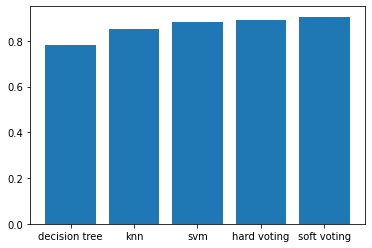

In [61]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5) # 0부터 5개 숫자들을 array 형태로 반환. 즉 [0,1,2,3,4]
plt.bar(x, height= [accuracy_score(y_test, dtree_predicted),
                    accuracy_score(y_test, knn_predicted),
                    accuracy_score(y_test, svm_predicted),
                    accuracy_score(y_test, hard_voting_predicted),
                    accuracy_score(y_test, soft_voting_predicted)])
plt.xticks(x, ['decision tree','knn','svm','hard voting','soft voting']);